Setting up the environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Importing necessary libraries
import tensorflow as tf # tensorflow 2.x
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Activation, Dropout, Lambda, Conv2DTranspose, AveragePooling2D, GaussianNoise
from keras.models import Model
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils.class_weight import compute_class_weight

from matplotlib import pyplot as plt
import matplotlib
import time
import numpy as np
from scipy import stats
from keras import metrics
import random
import math
import pandas as pd
import statistics

from tensorflow.keras.layers import Concatenate
from tensorflow.keras.regularizers import l2, l1

!pip install hic-straw
import hicstraw

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.13.4-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.4-py3-none-any.whl (240 kB)
  Created wheel for hic-straw: filename=hic_straw-1.3.1-cp310-cp310-linux_x86_64.whl size=1616775 sha256=5c82929a71f8725318ff966826896e0f8774fb2c6f39c72c8918e28101aa312b
  Stored in directory: /root/.cache/pip/wheels/23/85/e0/14f1be833ddf1da34165e04938653e00b602eb93e834497ae4
Successfully built hic-straw


In [2]:
# Setting up global variables

WIDTH=40 # Size of input matrix
res=50000 # resolution
br = matplotlib.colors.LinearSegmentedColormap.from_list("bright_red",[(1,1,1),(1,0,0)]) # color scheme
np.set_printoptions(suppress = True)
labels = ['0_to_0.25MB', '0.25_to_0.5MB', '0.5_to_1MB', '1_to_2MB', '2_to_5MB',
        '5_to_10MB', '10_to_20MB', '20+MB', 'Interchromosomal']
model = tf.keras.models.load_model("DistanceClassifier.h5")

In [3]:
# Loading testing files

!wget https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AABCOB3Zjebx87K5fLr6HZfsa/HIC784_deep.hic

files = ["HIC784_deep.hic"]

--2024-08-21 03:12:07--  https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AABCOB3Zjebx87K5fLr6HZfsa/HIC784_deep.hic
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/3eh3lbzedwc0hrg/AABCOB3Zjebx87K5fLr6HZfsa/HIC784_deep.hic [following]
--2024-08-21 03:12:07--  https://www.dropbox.com/sh/raw/3eh3lbzedwc0hrg/AABCOB3Zjebx87K5fLr6HZfsa/HIC784_deep.hic
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc432c5e85b2a1b6021c86bb49d2.dl.dropboxusercontent.com/cd/0/inline/CZD_-j0_sFSwLp9XRcAuKdJ3KRn3T1A2v4ybjlpO9LjAmSmTLEmie6daC-dCFz2l054u4aaU6oYLJurZcqqI8V2FRE9mYoI_kFuuC99JLo1A9xcukVNN5Pdj8M2R8LpmBk5sO4n-gUiK9kthMbXe92Hw/file# [following]
--2024-08-21 03:12:08--  https://uc432c5e85b2a1b6021c86bb49d2.dl.dropboxusercontent.com/cd/0/inline/CZD_-j0_sFSw

Preprocessing functions

In [4]:
# OE functions

# Averages out each diagonal
# For symmetric matrices, return an array with the values on each diagonal replaced by the average of that diagonal
def replace_diagonal_with_average(arr):
  max_offset = arr.shape[0]
  for i in range(1, max_offset):
    np.fill_diagonal(arr[:i, max_offset-i:], np.mean(np.diagonal(arr, offset=max_offset-i)))
    np.fill_diagonal(arr[max_offset-i:, :i], np.mean(np.diagonal(arr, offset=i-max_offset)))
  np.fill_diagonal(arr, np.mean(np.diagonal(arr)))

  return arr

# Return a WIDTH * WIDTH array of a near-diagonal expected matrix

def get_expected_matrix(hic, res, WIDTH, sample_size = 20, data_type = 'observed', normalization = 'NONE', unit = 'BP'):
  expected_matrix = np.zeros([WIDTH, WIDTH])
  expected_matrices = np.zeros([sample_size, WIDTH, WIDTH])
  chroms = hic.getChromosomes()
  num_chroms = len(chroms)-1
  for i in range(sample_size): # Sample of matrices taken
    scaffold = int(random.random()*num_chroms)+1 # Choosing random chromosome
    chr1_start = int(random.random()*(chroms[scaffold].length//res-(WIDTH-1))) * res # Choosing random start point
    matrix = hic.getMatrixZoomData(chroms[scaffold].name, chroms[scaffold].name, data_type, normalization, unit, res)
    matrix = matrix.getRecordsAsMatrix(chr1_start, chr1_start+(WIDTH-1)*res, chr1_start, chr1_start+(WIDTH-1)*res)
    expected_matrices[i, :, :] = replace_diagonal_with_average(matrix) # Creating expected matrix


  for i in range(WIDTH):
    for j in range(WIDTH):
      expected_matrix[i, j] = np.median(expected_matrices[:, i, j]) # Taking median of expected matrices to prevent skew from abnormal examples

  return expected_matrix

In [5]:
# Centile Rescaling

# Capping the matrix at a certain threshold and then linearly scaling between 0 and 1

def globalPercentileProcess(matrix, threshold):
  return np.where(matrix<threshold, matrix, threshold)/threshold

# Determine numerical value for centile
# Done very similarly to get_expected_matrix function above

def get_med_threshold(hic, centiles, res, WIDTH, sample_size = 20, data_type = 'observed', normalization = 'NONE', unit = 'BP'):
  thresholds=np.zeros([len(centiles), sample_size])
  chroms = hic.getChromosomes()
  num_chroms = len(chroms)-1

  for i in range(sample_size):
    chrom = int(random.random()*num_chroms)+1
    chr1_start = int(random.random()*(chroms[chrom].length//res-(WIDTH-1)))
    matrix = hic.getMatrixZoomData(chroms[chrom].name, chroms[chrom].name, data_type, normalization, unit, res)
    matrix = matrix.getRecordsAsMatrix(chr1_start, chr1_start+(WIDTH-1)*res, chr1_start, chr1_start+(WIDTH-1)*res)

    for idx, centile in enumerate(centiles):
      thresholds[idx, i] = np.percentile(matrix, centile) # Centile threshold calculated for each matrix

  final_thresholds = list()
  for i in range(len(centiles)):
    final_thresholds.append(statistics.median(thresholds[i]))

  return final_thresholds

In [6]:
# Centiles results modifications
# Populating the middle square of the matrix with 0s

def clearSquare(arr):
  size = arr.shape[1]
  li = size//2 - size//4
  ui = size//2 + size//4
  arr[:, li:ui, li:ui, :] = 0
  return arr

# Populating the sub, sub-sub, super, super-super, and regular diagonal with 0s

def clear_diagonal(array):
  WIDTH = array.shape[1]
  diagonal_indices = np.arange(WIDTH)

  array[:, diagonal_indices, diagonal_indices, :] = 0
  array[:, diagonal_indices[1:], diagonal_indices[:-1], :] = 0
  array[:, diagonal_indices[:-1], diagonal_indices[1:], :] = 0
  array[:, diagonal_indices[2:], diagonal_indices[:-2], :] = 0
  array[:, diagonal_indices[:-2], diagonal_indices[2:], :] = 0
  return array

# Returns just the upper triangular matrix

def clearBelowDiagonal(matrix):
  observed = matrix[:, :, 0]
  modified = np.copy(matrix)
  modified[:, :, 0] = np.triu(observed)
  return modified

# OE normalization options
preprocess = lambda x: np.tanh(np.log(x))
preprocess = lambda x: np.log(x+1)
preprocess = lambda x: np.tanh(x)

In [7]:
# Performing Gaussian blurring on an image

from scipy.signal.windows import gaussian

def gaussian_kernel(kernel_size, std):
    gk1d = gaussian(kernel_size, std).reshape(kernel_size, 1)
    gk2d = np.outer(gk1d, gk1d)
    return gk2d/gk2d.sum()

kernel_size = 5
std_dev = 1.0
gauss_kernel = gaussian_kernel(kernel_size, std_dev)

def blur(image_matrix, gauss_kernel, kernel_size):
  image_tensor = tf.reshape(image_matrix, [1, *image_matrix.shape, 1])
  gauss_kernel_tensor = tf.convert_to_tensor(gauss_kernel, dtype=image_tensor.dtype)
  gauss_kernel_tensor = tf.reshape(gauss_kernel_tensor, [kernel_size, kernel_size, 1, 1])
  blurred_image = tf.nn.conv2d(image_tensor, gauss_kernel_tensor, strides=[1, 1, 1, 1], padding="SAME")
  return blurred_image.numpy().squeeze()

Regular visualization

In [8]:
# Visualizing contiguous regions

hic = hicstraw.HiCFile(files[0])
chr = "CM000381.2"
p = 49100*1000 - 20*res
c=1 # Constant to change image WIDTH/resolution
test_res = res*c
test_WIDTH = WIDTH//c

thresholds = get_med_threshold(hic, [95, 90, 80], test_res, test_WIDTH)
expected_matrix = get_expected_matrix(hic, test_res, test_WIDTH)
input_matrix = np.zeros([1, test_WIDTH, test_WIDTH, 9])

fig, axs = plt.subplots(9, 11, figsize = (100, 100))
plt.subplots_adjust(wspace=0, hspace=-0.1)

for i in range(-5, 6):
  chr_start = p+i*test_res
  matrix = hic.getMatrixZoomData(chr, chr, "observed", "NONE", "BP", test_res)
  matrix = matrix.getRecordsAsMatrix(chr_start, chr_start + (test_WIDTH-1)*test_res, chr_start, chr_start + (test_WIDTH-1)*test_res)

  t1 = globalPercentileProcess(matrix, thresholds[0]) # Preprocessing
  t2 = globalPercentileProcess(matrix, thresholds[1])
  t3 = globalPercentileProcess(matrix, thresholds[2])

  input_matrix[0, :, :, 0] = t1
  input_matrix[0, :, :, 1] = t2
  input_matrix[0, :, :, 2] = t3

  input_matrix[:, :, :, 3:6] = input_matrix[:, :, :, :3]
  clear_diagonal(input_matrix[:, :, :, 3:6]) # Clearing diagonal
  input_matrix[:, :, :, 6:] = blur(input_matrix[:, :, :, :3], gauss_kernel, kernel_size) # Blurring

  for j in range(9):
    axs[j, i+5].imshow(input_matrix[0, :, :, j], cmap=br) # Visualization

  pred = np.argmax(model.predict(input_matrix)) # Model prediction
  axs[8, i+5].text(0, 30, labels[pred], size=50)

plt.savefig("784_deep_chr381_multiple_views_observedclearedblurred.png", bbox_inches='tight')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [9]:
# Fusions helper functions

# p1 and p2 are the positions in the chromosome
# o1 and o2 are the orientations of each piece, 0 is head and 1 is tail

def grabFromStraw(hic, res, chr1, p1, chr2, p2, WIDTH, data_type = 'observed', normalization = 'NONE', unit = 'BP'):

  matrix_chr1 = hic.getMatrixZoomData(chr1, chr1, data_type, normalization, unit, res)
  matrix_chr1 = matrix_chr1.getRecordsAsMatrix(p1, p1 + (WIDTH//2-1)*res, p1, p1 + (WIDTH//2-1)*res)

  matrix_chr2 = hic.getMatrixZoomData(chr2, chr2, data_type, normalization, unit, res)
  matrix_chr2 = matrix_chr2.getRecordsAsMatrix(p2, p2 + (WIDTH//2-1)*res, p2, p2 + (WIDTH//2-1)*res)

  matrix_comb = hic.getMatrixZoomData(chr1, chr2, data_type, normalization, unit, res)
  matrix_comb = matrix_comb.getRecordsAsMatrix(p1, p1 + (WIDTH//2-1)*res, p2, p2 + (WIDTH//2-1)*res) # Grabbing common region

  return matrix_chr1, matrix_chr2, matrix_comb

def getRegion(hic, res, chr1, p1, o1, chr2, p2, o2, WIDTH, data_type = 'observed', normalization = 'NONE', unit = 'BP'):

  matrix_chr1, matrix_chr2, matrix_comb = grabFromStraw(hic, res, chr1, p1, chr2, p2, WIDTH, data_type = data_type, normalization = normalization, unit = unit)

  type_break = o1*2+o2 # Each combination of break gives a different value for type_break
  output = np.zeros([WIDTH, WIDTH])

  # Stitching the matrices together with particular transformations for each value of type_break to create the proper chimeric matrix

  if type_break==0: # Both free ends are a head
    matrix_chr1 = np.flip(matrix_chr1, (0, 1))
    common1 = np.flipud(matrix_comb)
    common2 = np.rot90(matrix_comb, axes=(1, 0))

  elif type_break==1: # First region is a head, second region is a tail
    matrix_chr1 = np.flip(matrix_chr1, (0, 1))
    matrix_chr2 = np.flip(matrix_chr2, (0, 1))
    common1 = np.fliplr(np.flipud(matrix_comb))
    common2 = np.flipud(np.rot90(common1))

  elif type_break==2: # First region is a tail, second region is a head
    common1 = matrix_comb
    common2 = np.rot90(np.fliplr(matrix_comb))

  else: # First region is a tail, second region is a tail
    matrix_chr2 = np.flip(matrix_chr2, (0, 1))
    common1 = np.fliplr(matrix_comb)
    common2 = np.rot90(matrix_comb)

  i=WIDTH//2

  # Placing the smaller matrices in the final matrix

  output[:i, :i] = matrix_chr1
  output[i:, i:] = matrix_chr2
  output[:i, i:] = common1
  output[i:, :i] = common2

  return output

def visualizeFusions(hic, chr1, p1, o1, chr2, p2, o2, res, WIDTH, centiles = [], centiles_results_modified = [], oe_preprocess = [], model=None): # 0 - head, 1 - tail
  observed_matrix = getRegion(hic, res, chr1, p1, o1, chr2, p2, o2, WIDTH, data_type = 'observed', normalization = 'NONE', unit = 'BP')
  expected_matrix = get_expected_matrix(hic, res, WIDTH) # Getting expected matrix
  thresholds = get_med_threshold(hic, centiles, res, WIDTH) # Getting centile thresholds

  input_matrix = np.zeros([1, WIDTH, WIDTH, len(centiles) + len(centiles_results_modified) + len(oe_preprocess)])

  # Preprocessing with centiles
  for idx in range(len(centiles)):
    input_matrix[0, :, :, idx] = globalPercentileProcess(observed_matrix, thresholds[idx])

  # Other preprocessing methods on the centiles processed data
  for idx in range(len(centiles_results_modified)):
    input_matrix[0, :, :, len(centiles)*(idx+1):len(centiles)*(idx+2)] = centiles_results_modified[idx](input_matrix[0, :, :, :len(centiles)])

  # OE preprocessing
  for idx in range(len(oe_preprocess)):
    temp = np.nan_to_num(np.divide(np.copy(observed_matrix), expected_matrix), nan=0.0)
    input_matrix[0, :, :, len(centiles)+len(centiles_results_modified)+idx] = oe_preprocess[idx](temp)

  if model==None:
    return input_matrix

  return input_matrix, model.predict(input_matrix) # model prediction returned if model is provided

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Text(0, 30, 'Interchromosomal')

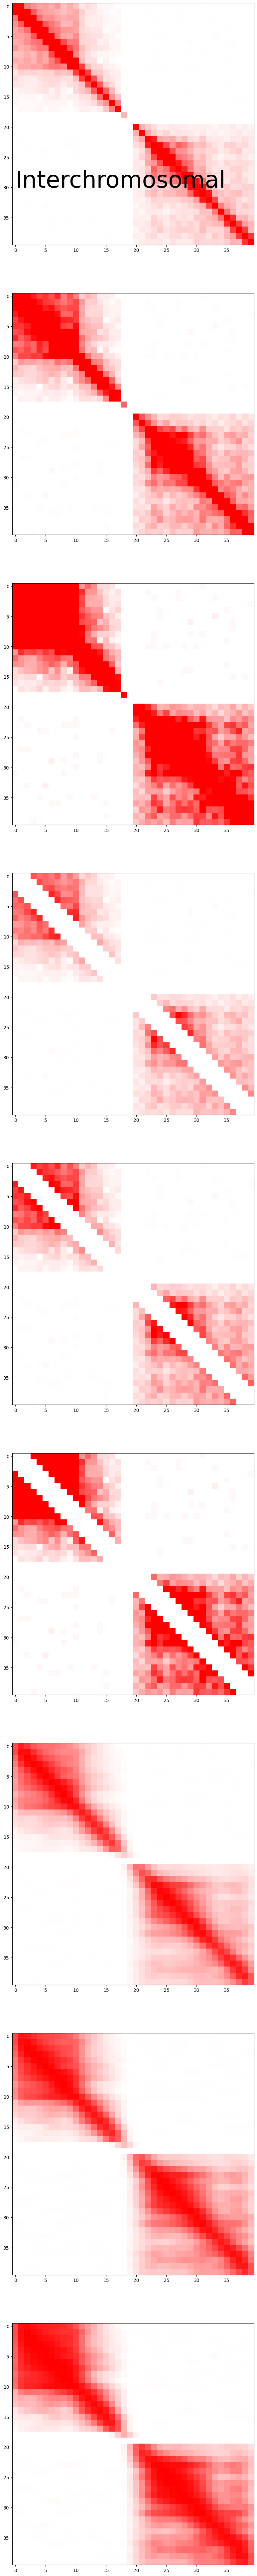

In [15]:
# Visualizing fusions

hic = hicstraw.HiCFile(files[0])

matrix = visualizeFusions(hic, "CM000378.2", 0, 0, "CM000379.2", 0, 0, res, WIDTH, centiles = [95, 90, 80], centiles_results_modified = [], oe_preprocess = [])
input_matrix = np.zeros([1, WIDTH, WIDTH, 9])
input_matrix[:, :, :, :3] = matrix
input_matrix[:, :, :, 3:6] = input_matrix[:, :, :, :3]
clear_diagonal(input_matrix[:, :, :, 3:6]) # clearing the matrix diagonal
input_matrix[:, :, :, 6:] = blur(input_matrix[:, :, :, :3], gauss_kernel, kernel_size) # gaussian blur on the matrix
prob = model.predict(input_matrix)
pred = np.argmax(prob) # Getting most likely class

fig, axs = plt.subplots(input_matrix.shape[-1], figsize = (100, 100))
for i in range(input_matrix.shape[-1]):
  axs[i].imshow(input_matrix[0, :, :, i], cmap=br) # Plotting

axs[0].text(0, 30, labels[pred], size=50)

Visualization after removing low-read bins

In [16]:
# Get the normalization vector for the specified chromosome and normalization
def getNormVector(hic, data_type='observed', normalization_type='VC', unit='BP', res=50000, percentiles=[0.5]):
  norm_vector = [] # Single list of all norm values throughout hic file
  chrom_vectors = [] # List of norm vectors for each chromosome
  chroms = hic.getChromosomes()
  for idx in range(len(chroms)-1): # Iterating through each chromosome
    chrom = chroms[idx+1]
    chr = hic.getMatrixZoomData(chrom.name, chrom.name, data_type, normalization_type, unit, res)
    nv = chr.getNormVector(idx+1) # Drawing norm vector
    chrom_vectors.append(nv)
    norm_vector.extend(nv.tolist())

  percentile_thresholds = []
  for percentile in percentiles:
    percentile_thresholds.append(np.percentile(norm_vector, percentile)) # Values for each percentile in the list of all norm values
  return percentile_thresholds, chrom_vectors

# valid_indices is the indexes of all high read bins
def getHighCoverageMatrix(matrix_chr, valid_indices, start_idx, end_idx, res, WIDTH):
  start = valid_indices[start_idx]
  end = valid_indices[end_idx]
  full_set = set(range(start, end + 1)) # Getting all values from start to end, inclusive
  missing_numbers = list(full_set - set(valid_indices[start_idx:end_idx+1])) # Removing all high read bins so only low read bins are left
  missing_numbers = [_-start for _ in missing_numbers] # Location of low read bins relative to start of the matrix
  matrix = matrix_chr.getRecordsAsMatrix(res*start, res*end, res*start, res*end)
  matrix = np.delete(matrix, missing_numbers, axis=0) # Deleting low read bins
  matrix = np.delete(matrix, missing_numbers, axis=1)

  return matrix, missing_numbers, start, end # Keeping track of which rows to delete

def find_largest_less_than(nums, target): # Finding index of the largest number in nums less than or equal to target
    left = 0
    right = len(nums) - 1
    result = -1

    while left <= right:
        mid = (left + right) // 2
        if nums[mid] <= target:
            result = mid
            left = mid + 1
        else:
            right = mid - 1

    return result

# Used to find start and endpoints of regions that will compose the chimeric matrix
# o is orientation

# The start and end indices may yield a matrix with length smaller than WIDTH because the matrix is near the beginning or end of the chromosome

def getStartEndIdx(o, valid_indices, idx, WIDTH):
  if o==0: # If region is a head
    # Start is first index greater than or equal to idx
    start = find_largest_less_than(valid_indices, idx)
    if not start==idx:
      start+=1
    end = min(len(valid_indices)-1, start+WIDTH-1) # End is WIDTH-1 away or very last index
  else: # If region is a tail
    end = find_largest_less_than(valid_indices, idx) # End is last index less than or equal to idx
    start = max(0, end-WIDTH+1) # Start is WIDTH-1 away or very first index
  return start, end

In [48]:
# Visualizing contiguous regions

hic = hicstraw.HiCFile(files[0])
chr = 5
chroms = hic.getChromosomes()
p = 49100*1000 - 25*res
c=1 # Constant to change image WIDTH/resolution
test_res = res*c
test_WIDTH = WIDTH//c
cv_threshold, cv_values = getNormVector(hic, res=test_res, percentiles=[0.75]) # Getting valid indexes
print(cv_threshold)
valid_indices = []
for _ in range(len(cv_values)):
  valid_indices.append([index for index, value in enumerate(cv_values[_]) if (value > cv_threshold[0])]) # Keeping only high read bins

thresholds = get_med_threshold(hic, [95, 90, 80], test_res, test_WIDTH)
expected_matrix = get_expected_matrix(hic, test_res, test_WIDTH)
input_matrix = np.zeros([1, test_WIDTH, test_WIDTH, 9])

fig, axs = plt.subplots(9, 11, figsize = (100, 100))
plt.subplots_adjust(wspace=0, hspace=-0.1)
chr_indices = valid_indices[chr-1] # Valid indices for the chromosome
target = p//test_res # Target index to start from
chr_start = find_largest_less_than(chr_indices, target)

# Start from target index or index right after target
if chr_indices[chr_start]==target:
    chr_start-=1
for i in range(11):
  chr_start += 1
  chr_end = min(len(chr_indices)-1, chr_start+test_WIDTH-1) # End index

  full_set = set(range(chr_indices[chr_start], chr_indices[chr_end] + 1)) # Getting all values from start to end, inclusive
  missing_numbers = list(full_set - set(chr_indices[chr_start:chr_end+1])) # Removing all high read bins so only low read bins are left
  missing_numbers = [_-chr_indices[chr_start] for _ in missing_numbers] # Location of low read bins relative to start of the matrix
  matrix = hic.getMatrixZoomData(chroms[chr].name, chroms[chr].name, "observed", "NONE", "BP", test_res)
  # Drawing big matrix from start to end
  matrix = matrix.getRecordsAsMatrix(res*chr_indices[chr_start], res*chr_indices[chr_end], res*chr_indices[chr_start], res*chr_indices[chr_end])
  matrix = np.delete(matrix, missing_numbers, axis=0) # Deleting low read bins
  matrix = np.delete(matrix, missing_numbers, axis=1)

  pad = test_WIDTH - matrix.shape[0]

  matrix = np.pad(matrix, ((0, pad), (0, pad)))

  t1 = globalPercentileProcess(matrix, thresholds[0]) # Preprocessing
  t2 = globalPercentileProcess(matrix, thresholds[1])
  t3 = globalPercentileProcess(matrix, thresholds[2])

  input_matrix[0, :, :, 0] = t1
  input_matrix[0, :, :, 1] = t2
  input_matrix[0, :, :, 2] = t3

  input_matrix[:, :, :, 3:6] = input_matrix[:, :, :, :3]
  clear_diagonal(input_matrix[:, :, :, 3:6]) # Clearing diagonal
  input_matrix[:, :, :, 6:] = blur(input_matrix[:, :, :, :3], gauss_kernel, kernel_size) # Blurring

  for j in range(9):
    axs[j, i].imshow(input_matrix[0, :, :, j], cmap=br) # Visualization

  pred = np.argmax(model.predict(input_matrix)) # Model prediction
  axs[8, i].text(0, 30, labels[pred], size=50)

plt.savefig("784_deep_chr381_multiple_views_observedclearedblurred.png", bbox_inches='tight')

[0.22708087408654923]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [17]:
# Fusions helper functions

# p1 and p2 are the positions in the chromosome
# vi1 and vi2 are the valid indices for chromosome 1 and chromosome 2
# o1 and o2 are the orientations of each piece, 0 is head and 1 is tail

def grabFromStraw(hic, res, chr1, p1, o1, vi1, chr2, p2, o2, vi2, WIDTH, data_type = 'observed', normalization = 'NONE', unit = 'BP'):

  # Grabbing bin indexes of the start points
  c1 = p1//res
  c2 = p2//res

  start_idx1, end_idx1 = getStartEndIdx(o1, vi1, c1, WIDTH//2) # Grabbing starting and ending indices based on valid indexes
  start_idx2, end_idx2 = getStartEndIdx(o2, vi2, c2, WIDTH//2)

  matrix_chr1 = hic.getMatrixZoomData(chr1, chr1, data_type, normalization, unit, res)
  matrix_chr2 = hic.getMatrixZoomData(chr2, chr2, data_type, normalization, unit, res)

  matrix_chr1, mn1, start1, end1 = getHighCoverageMatrix(matrix_chr1, vi1, start_idx1, end_idx1, res, WIDTH//2) # Grabbing region for each free end
  matrix_chr2, mn2, start2, end2 = getHighCoverageMatrix(matrix_chr2, vi2, start_idx2, end_idx2, res, WIDTH//2)

  matrix_comb = hic.getMatrixZoomData(chr1, chr2, data_type, normalization, unit, res)
  matrix_comb = matrix_comb.getRecordsAsMatrix(vi1[start_idx1]*res, vi1[end_idx1]*res, vi2[start_idx2]*res, vi2[end_idx2]*res) # Grabbing common region

  matrix_comb = np.delete(matrix_comb, mn1, axis=0) # Deleting low read bins from common region
  matrix_comb = np.delete(matrix_comb, mn2, axis=1)

  pad1 = WIDTH//2 - matrix_chr1.shape[0] # Padding if the matrix is smaller than WIDTH//2
  pad2 = WIDTH//2 - matrix_chr2.shape[0]

  # For each region, if it is a head, the padding will be added to the back, otherwise to the front

  if o1==0:
    matrix_chr1 = np.pad(matrix_chr1, ((0, pad1), (0, pad1)), mode='constant')
    matrix_comb = np.pad(matrix_comb, ((0, pad1), (0, 0)), mode='constant')
  else:
    matrix_chr1 = np.pad(matrix_chr1, ((pad1, 0), (pad1, 0)), mode='constant')
    matrix_comb = np.pad(matrix_comb, ((pad1, 0), (0, 0)), mode='constant')

  if o2==0:
    matrix_chr1 = np.pad(matrix_chr1, ((0, pad2), (0, pad2)), mode='constant')
    matrix_comb = np.pad(matrix_comb, ((0, 0), (0, pad2)), mode='constant')
  else:
    matrix_chr1 = np.pad(matrix_chr1, ((pad2, 0), (pad2, 0)), mode='constant')
    matrix_comb = np.pad(matrix_comb, ((0, 0), (pad2, 0)), mode='constant')

  return matrix_chr1, matrix_chr2, matrix_comb

def getRegion(hic, res, chr1, p1, o1, chr2, p2, o2, WIDTH, valid_indices, data_type = 'observed', normalization = 'NONE', unit = 'BP'):

  # Grabbing the correct list of valid indices
  for idx, chrom in enumerate(hic.getChromosomes()[1:]):
    if chr1==chrom.name:
      vi1 = valid_indices[idx]
    if chr2==chrom.name:
      vi2 = valid_indices[idx]

  matrix_chr1, matrix_chr2, matrix_comb = grabFromStraw(hic, res, chr1, p1, o1, vi1, chr2, p2, o2, vi2, WIDTH, data_type = data_type, normalization = normalization, unit = unit)

  type_break = o1*2+o2 # Each combination of break gives a different value for type_break
  output = np.zeros([WIDTH, WIDTH])

  # Stitching the matrices together with particular transformations for each value of type_break to create the proper chimeric matrix

  if type_break==0: # Both free ends are a head
    matrix_chr1 = np.flip(matrix_chr1, (0, 1))
    common1 = np.flipud(matrix_comb)
    common2 = np.rot90(matrix_comb, axes=(1, 0))

  elif type_break==1: # First region is a head, second region is a tail
    matrix_chr1 = np.flip(matrix_chr1, (0, 1))
    matrix_chr2 = np.flip(matrix_chr2, (0, 1))
    common1 = np.fliplr(np.flipud(matrix_comb))
    common2 = np.flipud(np.rot90(common1))

  elif type_break==2: # First region is a tail, second region is a head
    common1 = matrix_comb
    common2 = np.rot90(np.fliplr(matrix_comb))

  else: # First region is a tail, second region is a tail
    matrix_chr2 = np.flip(matrix_chr2, (0, 1))
    common1 = np.fliplr(matrix_comb)
    common2 = np.rot90(matrix_comb)

  i=WIDTH//2

  # Placing the smaller matrices in the final matrix

  output[:i, :i] = matrix_chr1
  output[i:, i:] = matrix_chr2
  output[:i, i:] = common1
  output[i:, :i] = common2

  return output

def visualizeFusions(hic, chr1, p1, o1, chr2, p2, o2, res, WIDTH, valid_indices, centiles = [], centiles_results_modified = [], oe_preprocess = [], model=None): # 0 - head, 1 - tail
  observed_matrix = getRegion(hic, res, chr1, p1, o1, chr2, p2, o2, WIDTH, valid_indices, data_type = 'observed', normalization = 'NONE', unit = 'BP')
  expected_matrix = get_expected_matrix(hic, res, WIDTH) # Getting expected matrix
  thresholds = get_med_threshold(hic, centiles, res, WIDTH) # Getting centile thresholds

  input_matrix = np.zeros([1, WIDTH, WIDTH, len(centiles) + len(centiles_results_modified) + len(oe_preprocess)])

  # Preprocessing with centiles
  for idx in range(len(centiles)):
    input_matrix[0, :, :, idx] = globalPercentileProcess(observed_matrix, thresholds[idx])

  # Other preprocessing methods on the centiles processed data
  for idx in range(len(centiles_results_modified)):
    input_matrix[0, :, :, len(centiles)*(idx+1):len(centiles)*(idx+2)] = centiles_results_modified[idx](input_matrix[0, :, :, :len(centiles)])

  # OE preprocessing
  for idx in range(len(oe_preprocess)):
    temp = np.nan_to_num(np.divide(np.copy(observed_matrix), expected_matrix), nan=0.0)
    input_matrix[0, :, :, len(centiles)+len(centiles_results_modified)+idx] = oe_preprocess[idx](temp)

  if model==None:
    return input_matrix
  return input_matrix, model.predict(input_matrix) # model prediction returned if model is provided

[0.22708087408654923]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Text(0, 30, 'Interchromosomal')

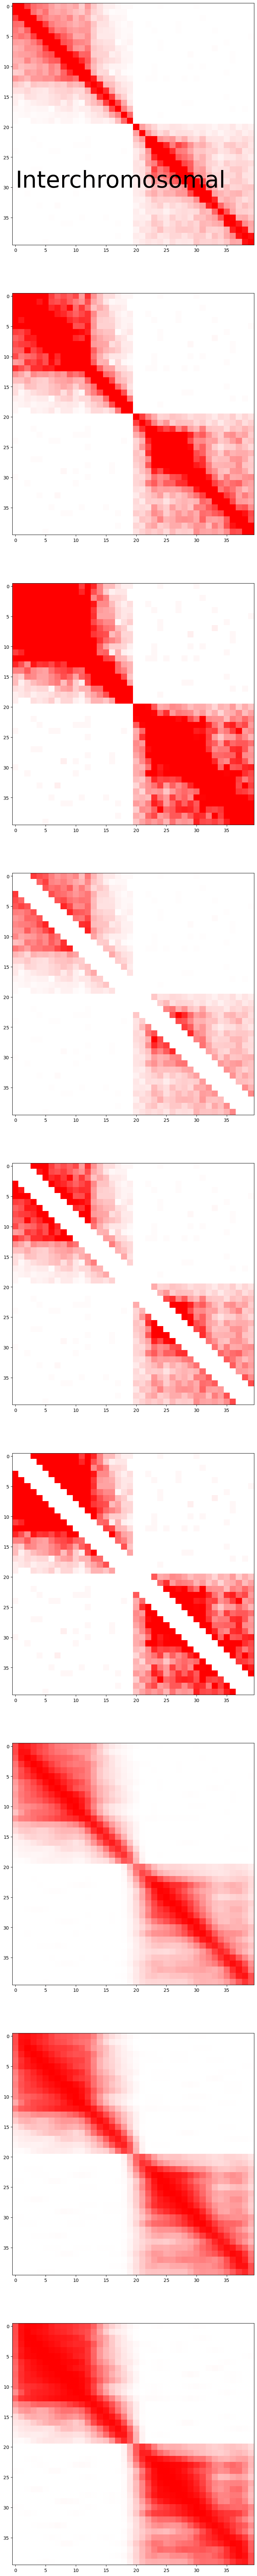

In [53]:
# Visualizing fusions

hic = hicstraw.HiCFile(files[0])
chroms = hic.getChromosomes()
cv_threshold, cv_values = getNormVector(hic, res=res, percentiles=[0.75]) # Getting valid indexes
print(cv_threshold)
valid_indices = []
for _ in range(len(cv_values)):
  valid_indices.append([index for index, value in enumerate(cv_values[_]) if (value > cv_threshold[0])]) # Keeping only high read bins

matrix = visualizeFusions(hic, "CM000378.2", 0, 0, "CM000379.2", 0, 0, res, WIDTH, valid_indices, centiles = [95, 90, 80], centiles_results_modified = [], oe_preprocess = [])
input_matrix = np.zeros([1, WIDTH, WIDTH, 9])
input_matrix[:, :, :, :3] = matrix
input_matrix[:, :, :, 3:6] = input_matrix[:, :, :, :3]
clear_diagonal(input_matrix[:, :, :, 3:6]) # clearing the matrix diagonal
input_matrix[:, :, :, 6:] = blur(input_matrix[:, :, :, :3], gauss_kernel, kernel_size) # gaussian blur on the matrix
prob = model.predict(input_matrix)
pred = np.argmax(prob) # Getting most likely class

fig, axs = plt.subplots(input_matrix.shape[-1], figsize = (100, 100))
for i in range(input_matrix.shape[-1]):
  axs[i].imshow(input_matrix[0, :, :, i], cmap=br) # Plotting

axs[0].text(0, 30, labels[pred], size=50)